# CG(TVなし)

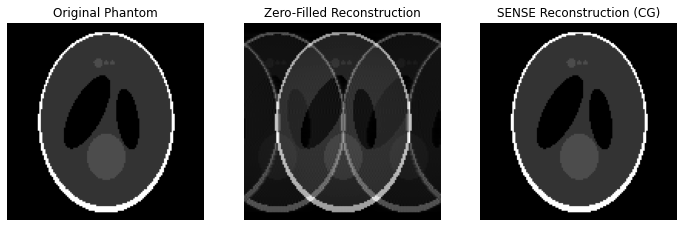

In [13]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# コイル感度マップの生成 (birdcage model, 4 coils)
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# k-space の計算 (各コイルごとに感度をかけて Fourier 変換)
ksp = np.array([sp.fft(phantom * mps[i], axes=(-1, -2)) for i in range(num_coils)])

# 1D undersampling マスク（位相エンコード方向のみ間引く）
mask = np.ones(img_shape)  # 全体を 1 で初期化
mask[:, ::3] = 0  # 3倍加速 (位相エンコード方向で1/3のサンプルのみ使用)
ksp_sampled = ksp * mask  # 各コイルに適用

# FFT 演算子（axes を明示的に指定）
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))

# 感度マップ適用演算子 (num_coils の次元を考慮)
S = sp.linop.Multiply(img_shape, mps)

# サンプリングマスク演算子 (num_coils, Ny, Nx の形で mask を適用)
P = sp.linop.Multiply(ksp.shape, mask)  # (num_coils, Ny, Nx) に適用

# SENSE の線形オペレータ
A = P * F * S  # 順方向モデル

# 逆演算を考慮して SENSE の A^H * A の形を構築
AHA = A.H * A  # A^H * A の計算
b = A.H(ksp_sampled)  # 右辺 b = A^H * y の計算

# CG による SENSE 再構成
x = np.zeros(img_shape, dtype=np.complex128)  # 初期化
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

while not cg_solver.done():
    cg_solver.update()

# 再構成画像（複素数の絶対値）
reconstructed_img = np.abs(x)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(np.sum(sp.ifft(ksp_sampled, axes=(-1, -2)), axis=0)), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("SENSE Reconstruction (CG)")
axs[2].axis("off")

plt.show()


# CG法(TV正則化あり)

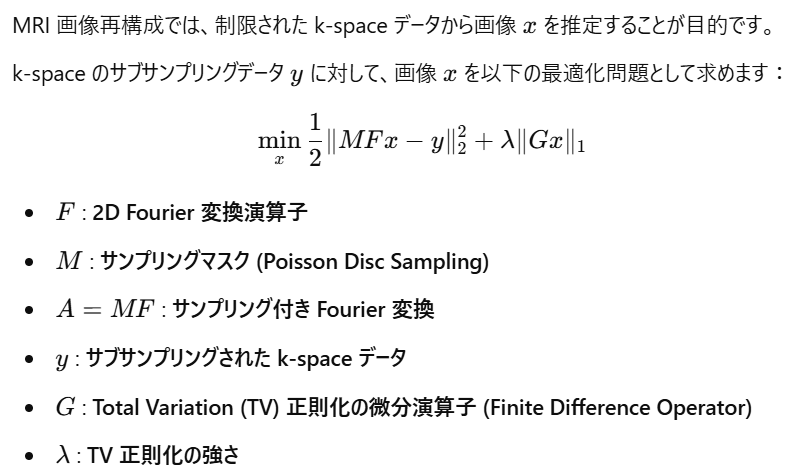

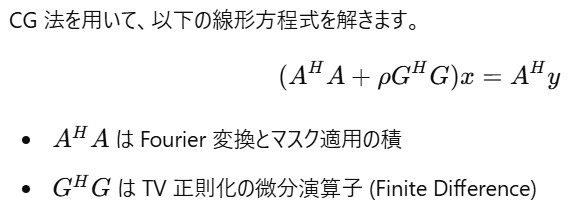

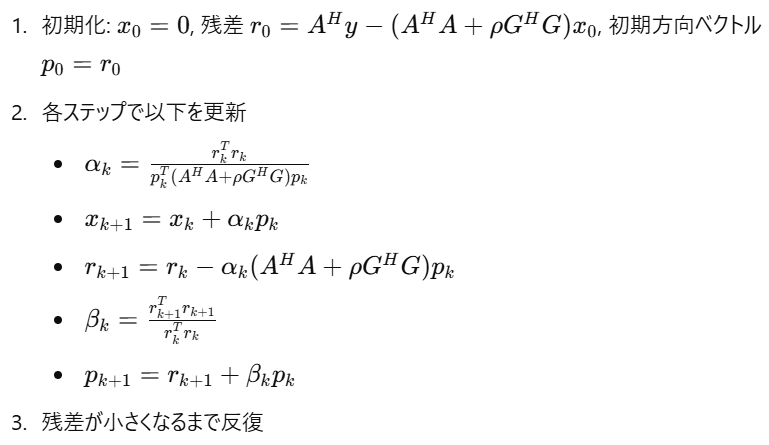

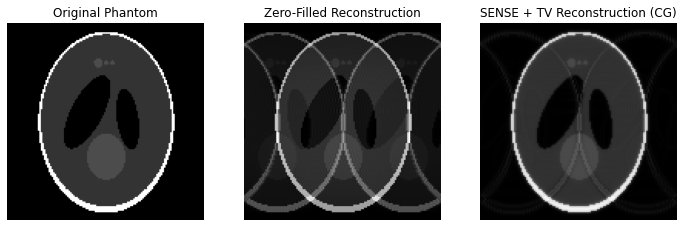

In [16]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# コイル感度マップの生成 (birdcage model, 4 coils)
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# k-space の計算 (各コイルごとに感度をかけて Fourier 変換)
ksp = np.array([sp.fft(phantom * mps[i], axes=(-1, -2)) for i in range(num_coils)])

# 1D undersampling マスク（位相エンコード方向のみ間引く）
mask = np.ones(img_shape)  # 全体を 1 で初期化
mask[:, ::3] = 0  # 3倍加速 (位相エンコード方向で1/3のサンプルのみ使用)
ksp_sampled = ksp * mask  # 各コイルに適用

# FFT 演算子（axes を明示的に指定）
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))

# 感度マップ適用演算子 (num_coils の次元を考慮)
S = sp.linop.Multiply(img_shape, mps)

# サンプリングマスク演算子 (num_coils, Ny, Nx の形で mask を適用)
P = sp.linop.Multiply(ksp.shape, mask)

# SENSE の線形オペレータ
A = P * F * S  # 順方向モデル

# TV 正則化オペレータ（x, y 方向の微分）
G = sp.linop.FiniteDifference(img_shape, axes=[0, 1])  # TV 正則化演算子

# TV 正則化の係数
rho = 0.1  # 正則化強度（適宜調整）

# 逆演算を考慮して SENSE + TV の A^H * A の形を構築
AHA = A.H * A + rho * G.H * G  # 正則化項を追加
b = A.H(ksp_sampled)  # 右辺 b = A^H * y の計算

# CG による SENSE + TV 再構成
x = np.zeros(img_shape, dtype=np.complex128)  # 初期化
cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=100, tol=1e-6)

while not cg_solver.done():
    cg_solver.update()

# 再構成画像（複素数の絶対値）
reconstructed_img = np.abs(x)

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(np.sum(sp.ifft(ksp_sampled, axes=(-1, -2)), axis=0)), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("SENSE + TV Reconstruction (CG)")
axs[2].axis("off")

plt.show()
